### The main goal of this notebook is to help interpretation of the coherence matrix of ISMN station "FordDryLake"

The coherence matrices for three Sentinel-1 orbits (100, 166, 173) at the ISMN station "FordDryLake" are calculated.

In [215]:
#---------------------Import libraries --------------
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import shapely
import os
from collections import Counter
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

#--------------------- INSAR4SM functionalities --------------
from insar4sm.classes import INSAR4SM_stack, SM_point
from insar4sm.gridding import WGS84_to_UTM
from insar4sm.forward_modelling_funcs import Covar_modelled_calc

Set arguments

In [2]:
ISMN_station = 'FordDryLake'

# orbit information
combs = [['173','14:00:00'],
         ['100','14:00:00'],
         ['166','02:00:00']]

# spatial information
grid_sizes = np.arange(25, 425, 25)

Function that generates an polygon given center and radius

In [3]:
def create_buffer_poly(ISMN_station_file: str, grid_size: float, save: bool = True ) -> shapely.geometry.polygon.Polygon:

    # convert wgs geometry to projection system

    ISMN_station_loc_wgs84 = gpd.read_file(ISMN_station_file)
    ISMN_station_loc_wgs84.crs = "EPSG:4326"

    lon = ISMN_station_loc_wgs84['geometry'][0].x
    lat = ISMN_station_loc_wgs84['geometry'][0].y
    utm_crs_epsg = WGS84_to_UTM(lon, lat)    

    ISMN_station_loc_UTM = ISMN_station_loc_wgs84.to_crs(epsg=utm_crs_epsg).iloc[0].geometry

    ISMN_station_loc_UTM_buffer = ISMN_station_loc_UTM.buffer(grid_size, cap_style = 1)

    ISMN_station_loc_buffer = gpd.GeoDataFrame(index=[0], crs=utm_crs_epsg, geometry=[ISMN_station_loc_UTM_buffer])

    ISMN_station_loc_buffer = ISMN_station_loc_buffer.to_crs(epsg=4326)

    if save:
        save_dir = os.path.dirname(ISMN_station_file)
        filename = os.path.join(os.path.basename(ISMN_station_file).split('.')[0]+'_'+str(grid_size)+'.geojson')
        ISMN_station_loc_buffer.to_file(os.path.join(save_dir,filename), driver="GeoJSON")  

    return ISMN_station_loc_buffer.geometry



### For Orbit 100

In [6]:
combs = [['173','14:00:00'],
         ['100','14:00:00'],
         ['166','02:00:00']]
orbit_num,  orbit_time_UTC =  combs[1]
grid_size = 125

In [176]:
ISMN_csv = '/RSL02/SM_NA/ISMN/{}/ismn_station_{}.csv'.format(ISMN_station, ISMN_station)
IMSN_df = pd.read_csv(ISMN_csv)
IMSN_df.index = pd.to_datetime(IMSN_df['Datetime'])
IMSN_df = IMSN_df['sm_plot']
# select only particular hour
IMSN_df = IMSN_df.at_time(orbit_time_UTC).to_frame()

In [7]:
###############################################################################
# the name of your experiment
projectname = 'INSAR4SM_ISMN_coh_experiment_{}_sq{}_{}'.format(orbit_num, grid_size, ISMN_station)

# the directory of the topstack processing
topstackDir = '/RSL02/SM_NA/Topstack_processing_orbit_{}'.format(orbit_num)

# the AOI geojson file for your project
# ensure that AOI is inside your topstack stack
#AOI = '/RSL02/SM_NA/Plotting/bbox_aoi.geojson'
AOI = '/RSL02/SM_NA/ISMN/{}/{}_AOI.geojson'.format(ISMN_station,ISMN_station)

# the meteorological file. You can either provide an ERA5-land file or a csv file with 3 columns (Datetimes, tp__m, skt__K).
meteo_file = '/RSL02/SM_NA/era5/era5_land_na_orbit_{}.nc'.format(orbit_num)
# set to True in case you provide an ERA5-Land file
ERA5_flag = True
# In case you downloaded surface soil moisture from ERA5-land, set to True for comparison purposes
ERA5_sm_flag = True

# the output directory 
export_dir = '/RSL02/SM_NA/{}'.format(projectname)

# soil information datasets (https://soilgrids.org/)
sand_soilgrids = 87
clay_soilgrids = 13

# the insitu measurements in csv format
ISMN_csv = '/RSL02/SM_NA/ISMN/{}/ismn_station_{}.csv'.format(ISMN_station, ISMN_station)

# geometrical infromation regarding ISMN station

ISMN_station_loc = '/RSL02/SM_NA/ISMN/{}/{}_location.geojson'.format(ISMN_station,ISMN_station)

IMSN_polygon = create_buffer_poly(ISMN_station_loc, grid_size )

ISMN_point = IMSN_polygon.centroid

stack = INSAR4SM_stack(topstackDir = topstackDir,
                projectname = projectname,
                AOI = AOI,
                meteo_file = meteo_file,
                ERA5_flag = ERA5_flag,
                sand = sand_soilgrids,
                clay = clay_soilgrids,
                orbit_time = orbit_time_UTC,
                export_dir = export_dir)

stack.prepare_datasets()
stack.plot()
stack.get_dry_SARs()
stack.calc_insar_stack()

stack.sm_points = ISMN_point
stack.sm_polygons = IMSN_polygon
stack.n_sm_points = len(stack.sm_points)


number of SLCs discovered:  22
creating directory: /RSL02/SM_NA/INSAR4SM_ISMN_coh_experiment_100_sq125_FordDryLake/INSAR4SM_ISMN_coh_experiment_100_sq125_FordDryLake/INSAR4SM_datasets/slcs
write vrt file for each SLC ...
creating stack directory: /RSL02/SM_NA/INSAR4SM_ISMN_coh_experiment_100_sq125_FordDryLake/INSAR4SM_ISMN_coh_experiment_100_sq125_FordDryLake/INSAR4SM_datasets/coreg_stack
write vrt file for stack directory
creating geometry directory: /RSL02/SM_NA/INSAR4SM_ISMN_coh_experiment_100_sq125_FordDryLake/INSAR4SM_ISMN_coh_experiment_100_sq125_FordDryLake/INSAR4SM_datasets/geometry
write vrt file for geometry dataset


In [8]:
sm_point_ts = SM_point(stack, sm_ind=0)

In [21]:
sm_point_ts.get_DS_info(stack)

By selecting only a subset of pixels in the selected we have better homogeneity (lower std in each SAR image) of pixels in terms of intensity

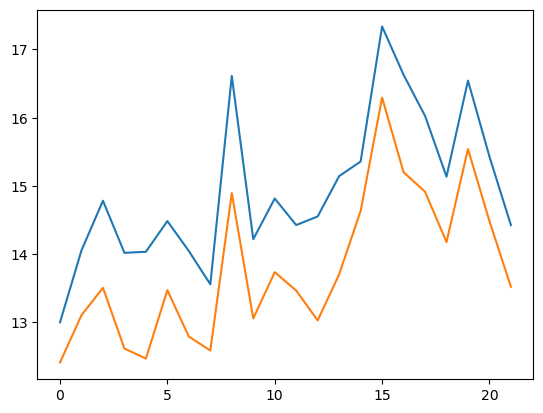

In [39]:
plt.plot(np.std(sm_point_ts.DS_amp_values, axis=1))
plt.plot(np.std(sm_point_ts.DS_amp_values_amp_ph, axis=1))

By selecting only a subset of pixels in the selected we a lower std of interferometric phase between pixels.

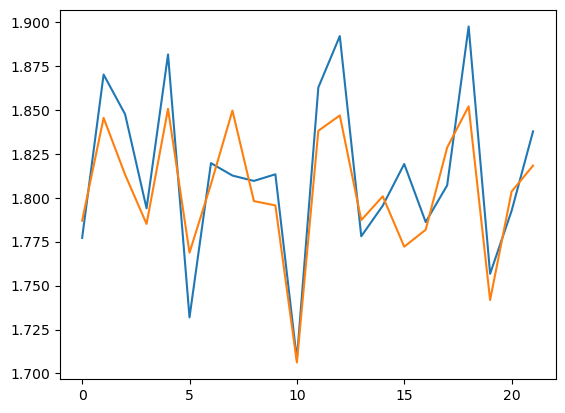

In [40]:
plt.plot(np.std(np.angle(sm_point_ts.DS_slc_values), axis=1))
plt.plot(np.std(np.angle(sm_point_ts.DS_slc_values_amp_ph), axis=1))

In [65]:
sm_point_ts.calc_covar_matrix()
sm_point_ts.get_DS_geometry(stack)
sm_point_ts.calc_driest_date()
sm_point_ts.calc_sm_sorting()
sm_point_ts.calc_sm_coherence()
sm_point_ts.calc_sm_index()
sm_point_ts.inversion()

In [177]:
sm_df = pd.DataFrame(sm_point_ts.SM0)
sm_df.index = pd.to_datetime(sm_point_ts.slc_dates)
sm_df.index = sm_df.index + pd.Timedelta('{} hour'.format(pd.to_datetime(orbit_time_UTC).hour))
sm_ISMN_df = IMSN_df.join(sm_df, how='outer').dropna()
sm_ISMN_df['Datetime'] = sm_ISMN_df.index
sm_ISMN_df = sm_ISMN_df['sm_plot']

# fig, ax = plt.subplots(1,1, figsize=(8, 8))
# img = ax.imshow(sm_point_ts.DS_Coh0[:,:])
# y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
# ax.set_yticks(np.arange(len(y_label_list)))
# ax.set_yticklabels(y_label_list)
# fig.colorbar(img)
# sm_ISMN_df.plot()

Calculating modelled coherence using soil moisture index

In [ ]:
coh_forward_index_model = np.zeros((22,22))
sm_ISMN_df_log = np.log(sm_ISMN_df)
for i in range(22):
    for j in range(22):
        if i == j:
            coh_forward_index_model[i,j] = 1
        else:
            coh_forward_index_model[i,j] = np.exp(-np.abs(sm_ISMN_df_log.iloc[i]-sm_ISMN_df_log.iloc[j]))

# fig, ax = plt.subplots(1,1, figsize=(8, 8))
# img = ax.imshow(coh_forward_index_model)
# y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
# ax.set_yticks(np.arange(len(y_label_list)))
# ax.set_yticklabels(y_label_list)
# fig.colorbar(img)

Calculating modelled coherence using De Zan`s model

In [ ]:
coh_forward_de_zan_model = Covar_modelled_calc(sm_ISMN_df.values, sm_point_ts.inc_DS[0], sm_point_ts.freq_GHz, sm_point_ts.clay_pct, sm_point_ts.sand_pct, None)

# fig, ax = plt.subplots(1,1, figsize=(8, 8))
# img = ax.imshow(np.abs(coh_forward_de_zan_model))
# y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
# ax.set_yticks(np.arange(len(y_label_list)))
# ax.set_yticklabels(y_label_list)
# fig.colorbar(img)


PLot Observed and Modelled Coherence matrices

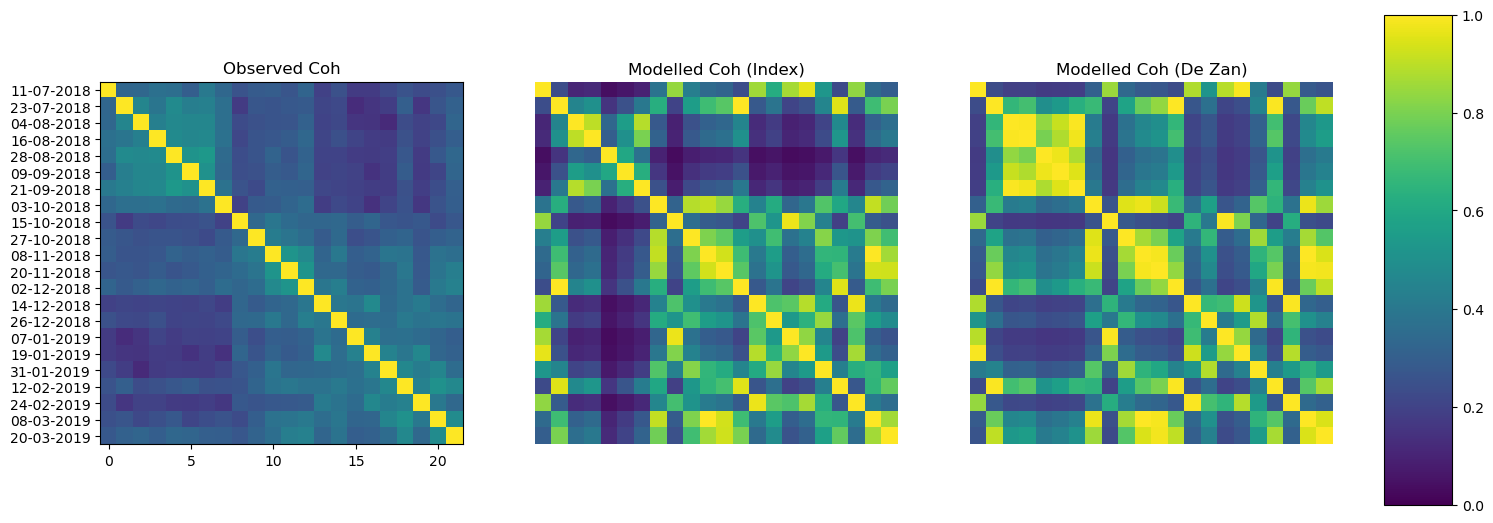

In [272]:
fig, ax = plt.subplots(1, 3, figsize=(17, 7))

img = ax[0].imshow(sm_point_ts.DS_Coh0, vmin=0, vmax=1)
y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
ax[0].set_yticks(np.arange(len(y_label_list)))
ax[0].set_yticklabels(y_label_list)
ax[0].set_title('Observed Coh')

img = ax[1].imshow(coh_forward_index_model, vmin=0, vmax=1)
y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
ax[1].set_title('Modelled Coh (Index)')
ax[1].axis('off')


img = ax[2].imshow(np.abs(coh_forward_de_zan_model), vmin=0, vmax=1)
y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
ax[2].set_title('Modelled Coh (De Zan)')
ax[2].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)

In [273]:
num_tri_elements = np.triu_indices_from(coh_forward_index_model,1)[0].shape[0]
num_tri_indices = np.triu_indices_from(coh_forward_index_model,1)

In [274]:
raw_coh_vector = sm_point_ts.DS_Coh0[num_tri_indices]
coh_forward_index_model_vector = coh_forward_index_model[num_tri_indices]
coh_forward_de_zan_model_vector = np.abs(coh_forward_de_zan_model)[num_tri_indices]

In [276]:
from scipy import stats
x = raw_coh_vector
y = coh_forward_index_model_vector
z = coh_forward_de_zan_model_vector

#regression part between observed and modelled(Index)
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x,y)
line1 = slope1*x+intercept1

#regression part between observed and modelled(De Zan)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x,z)
line2 = slope2*x+intercept2

#regression part between modelled(Index) and modelled(De Zan)
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(y,z)
line3 = slope3*y+intercept3

Plot scatterplots between Observed and modelled coherences

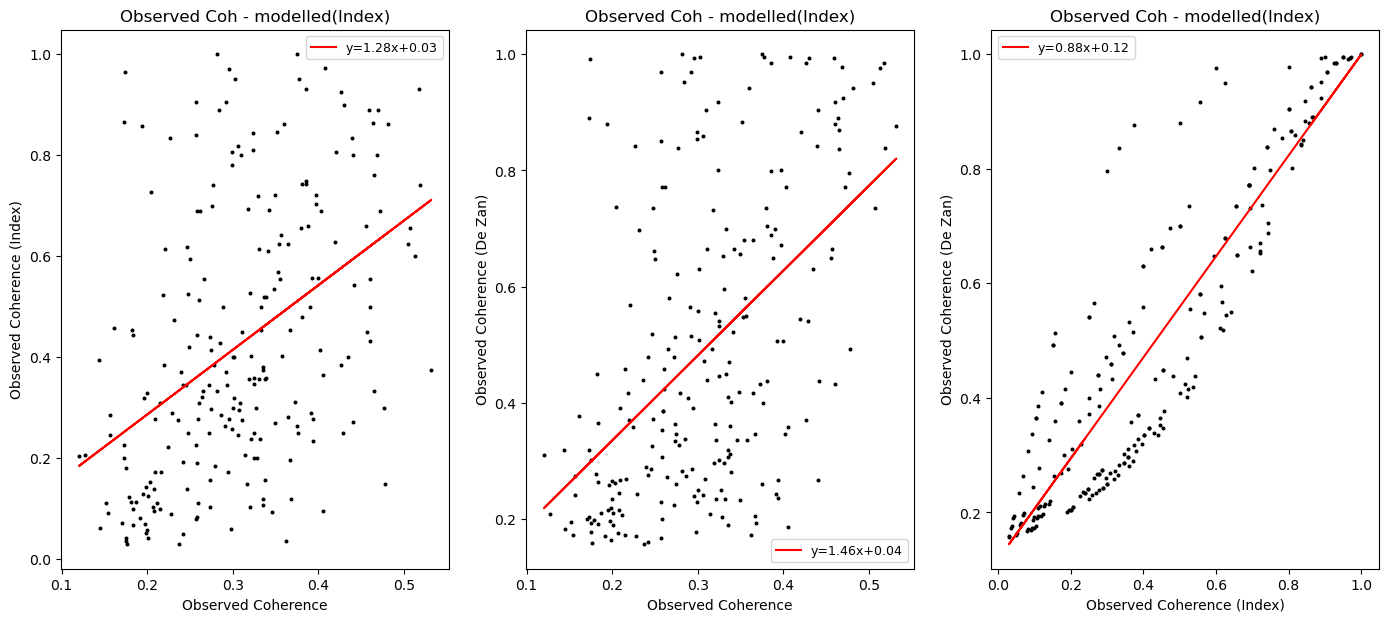

In [283]:
fig, ax = plt.subplots(1, 3, figsize=(17, 7))

ax[0].plot(x, line1, 'r', label='y={:.2f}x+{:.2f}'.format(slope1,intercept1))
ax[0].scatter(x,y, color="k", s=3.5)
ax[0].set_title('Observed Coh - modelled(Index)')
ax[0].set_xlabel('Observed Coherence')
ax[0].set_ylabel('Observed Coherence (Index)')
ax[0].legend(fontsize=9)

ax[1].plot(x, line2, 'r', label='y={:.2f}x+{:.2f}'.format(slope2,intercept2))
ax[1].scatter(x,z, color="k", s=3.5)
ax[1].set_title('Observed Coh - modelled(Index)')
ax[1].set_xlabel('Observed Coherence')
ax[1].set_ylabel('Observed Coherence (De Zan)')
ax[1].legend(fontsize=9)

ax[2].plot(y, line3, 'r', label='y={:.2f}x+{:.2f}'.format(slope3,intercept3))
ax[2].scatter(y,z, color="k", s=3.5)
ax[2].set_title('Observed Coh - modelled(Index)')
ax[2].set_xlabel('Observed Coherence (Index)')
ax[2].set_ylabel('Observed Coherence (De Zan)')
ax[2].legend(fontsize=9)

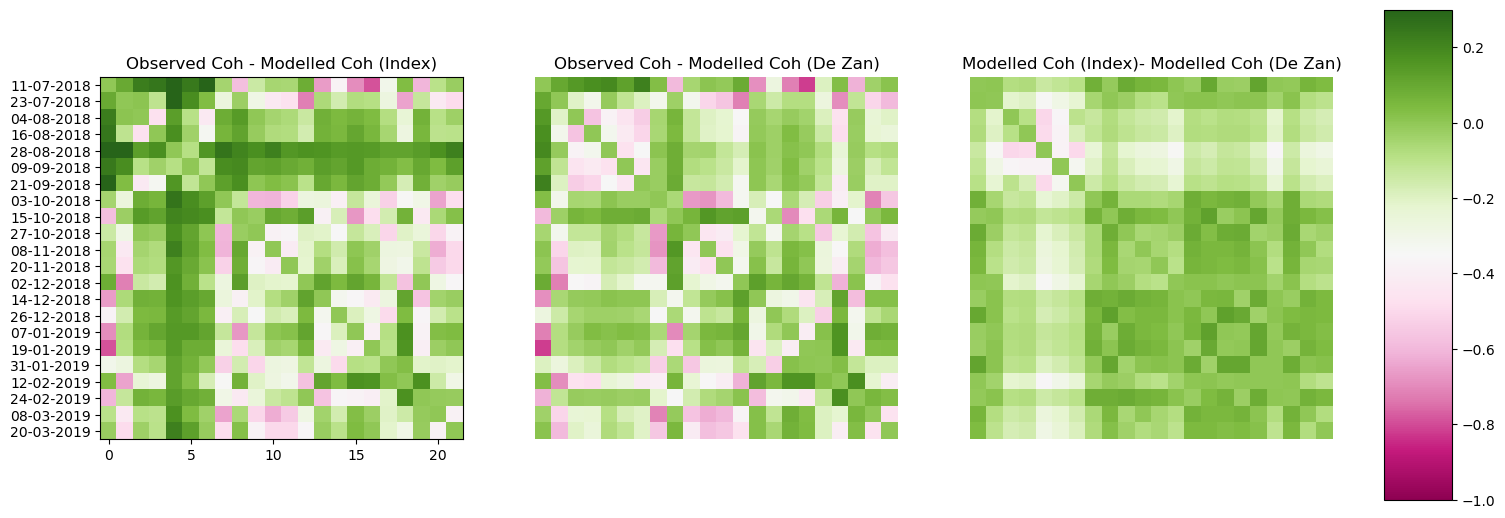

In [300]:
fig, ax = plt.subplots(1, 3, figsize=(17, 7))

ax[0].imshow(sm_point_ts.DS_Coh0-coh_forward_index_model, cmap=mpl.colormaps['PiYG'], vmin=-1, vmax=0.3)
y_label_list = [sar_datetime.strftime('%d-%m-%Y') for sar_datetime in sm_point_ts.slc_dates.date]
ax[0].set_yticks(np.arange(len(y_label_list)))
ax[0].set_yticklabels(y_label_list)
ax[0].set_title('Observed Coh - Modelled Coh (Index)')

ax[1].imshow(sm_point_ts.DS_Coh0 - np.abs(coh_forward_de_zan_model), cmap=mpl.colormaps['PiYG'], vmin=-1, vmax=0.3)
ax[1].set_title('Observed Coh - Modelled Coh (De Zan)')
ax[1].axis('off')

img = ax[2].imshow(coh_forward_index_model-np.abs(coh_forward_de_zan_model),cmap=mpl.colormaps['PiYG'], vmin=-1, vmax=0.3)
ax[2].set_title('Modelled Coh (Index)- Modelled Coh (De Zan)')
ax[2].axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(img, cax=cbar_ax)

Text(0.5, 1.0, 'ISMN SM volumetric (0-100)')

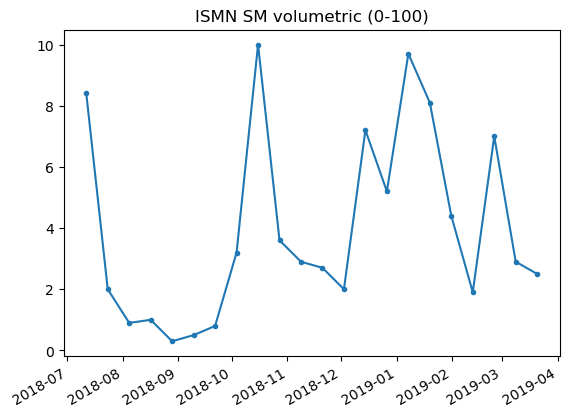

In [301]:
sm_ISMN_df.plot(style='.-')
plt.title('ISMN SM volumetric (0-100)')